## Import Dependencies

In [1]:
# misc
import math
import time
from pathlib import Path
from fractions import Fraction

# scientific
import numpy as np
import beatbrain
from beatbrain import utils

# visualization
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Tensorflow
import tensorflow as tf

from tensorflow.keras import Model, Sequential, Input, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    AveragePooling2D,
    Dense,
    Lambda,
    Reshape,
    Flatten,
    Layer,
    concatenate,
    Add,
    Subtract,
    Multiply,
    BatchNormalization,
    ReLU,
    Activation,
)
from tensorflow.keras.callbacks import (
    Callback,
    TensorBoard,
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TerminateOnNaN,
    CSVLogger,
    LambdaCallback,
)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
sns.set()
sns.set_style("white")
%matplotlib inline

## Load Datasets

In [4]:
# Input
DATA_ROOT = Path("../data/fma/image")
IMAGE_DIMS = [512, 640, 1]
BATCH_SIZE = 4

In [5]:
train_dataset = utils.load_dataset(
    DATA_ROOT / "train", batch_size=BATCH_SIZE, parallel=False,
)
val_dataset = utils.load_dataset(
    DATA_ROOT / "val", batch_size=BATCH_SIZE, parallel=False,
)
test_dataset = utils.load_dataset(
    DATA_ROOT / "test", batch_size=1, parallel=False, shuffle_buffer=0,
)

Checking input type(s) in '/media/data/beatbrain_data/fma/image/train'...
Determined input type to be 'IMAGE'
Checking input type(s) in '/media/data/beatbrain_data/fma/image/val'...
Determined input type to be 'IMAGE'
Checking input type(s) in '/media/data/beatbrain_data/fma/image/test'...
Determined input type to be 'IMAGE'


## Define Model Architecture

In [6]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
        -0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis
    )


@tf.function
def sample(latent_dim, decoder, eps=None):
    if eps is None:
        eps = tf.random.normal(shape=(100, latent_dim))
    return decode(decoder, eps, apply_sigmoid=True)


def encode(encoder, x):
    inference = encoder(x)
    mean, logvar = tf.split(inference, num_or_size_splits=2, axis=1)
    return mean, logvar


def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * 0.5) + mean


def decode(decoder, z, apply_sigmoid=False):
    logits = decoder(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits

In [7]:
# Custom layers
class NormConv2D(Layer):
    """
    Batch-normalized, ReLU-activated convolution or transpose convolution
    """
    def __init__(self, filters, kernel_size, transpose=False):
        self._kernel_size = kernel_size
        self._filters = filters
        self._transpose = transpose
        super().__init__()

    def build(self, input_shape):
        conv_layer = Conv2DTranspose if self._transpose else Conv2D
        self._model = Sequential([
            conv_layer(self._filters, self._kernel_size, padding="SAME",),
            BatchNormalization(),
            ReLU(),
        ])
        super().build(input_shape)

    def call(self, x):
        return self._model(x)

    def compute_output_shape(self, input_shape):
        return self._model.compute_output_shape(input_shape)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "filters": self._filters,
            "kernel_size": self._kernel_size,
            "transpose": self._transpose,
        })
        return config


class Inception2D(Layer):
    def __init__(self, filters, transpose=False):
        self._filters = filters
        self._transpose = transpose
        super().__init__()

    def build(self, input_shape):
        filters = self._filters
        print(input_shape)
        inputs = Input(shape=input_shape[1:])
        bottleneck = NormConv2D(filters, 1, transpose=self._transpose)(inputs)

        conv1 = NormConv2D(filters, 1, transpose=self._transpose)(bottleneck)
        conv3 = NormConv2D(filters, 3, transpose=self._transpose)(bottleneck)
        conv5 = NormConv2D(filters, 5, transpose=self._transpose)(bottleneck)
        conv7 = NormConv2D(filters, 7, transpose=self._transpose)(bottleneck)
        pool3 = MaxPool2D(pool_size=3, strides=1, padding="SAME")(inputs)
        pool5 = MaxPool2D(pool_size=5, strides=1, padding="SAME")(inputs)
        merged = Add()([conv1, conv3, conv5, conv7, pool3, pool5])
        self._model = Model(inputs=inputs, outputs=merged)
        super().build(input_shape)

    def call(self, x):
        return self._model(x)

    def compute_output_shape(self, input_shape):
        return self._model.compute_output_shape(input_shape)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "filters": self._filters,
            "transpose": self._transpose,
        })
        return config


class DownSample2D(Layer):
    def __init__(self, filters, pool_kernel_size):
        self._filters = filters
        self._pool_kernel_size = pool_kernel_size
        super().__init__()

    def build(self, input_shape):
        self._model = Sequential(
            [
                AveragePooling2D(self._pool_kernel_size),
                Conv2D(self._filters, 1),
                BatchNormalization(),
                ReLU(),
            ],
        )
        super().build(input_shape)

    def call(self, x):
        return self._model(x)

    def compute_output_shape(self, input_shape):
        return self._model.compute_output_shape(input_shape)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "filters": self._filters,
            "pool_kernel_size": self._pool_kernel_size,
        })
        return config


class UpSample2D(Layer):
    def __init__(self, filters, pool_kernel_size):
        self._filters = filters
        self._pool_kernel_size = pool_kernel_size
        super().__init__()

    def build(self, input_shape):
        self._model = Sequential(
            [
                Conv2DTranspose(self._filters, 1, strides=self._pool_kernel_size),
                BatchNormalization(),
                ReLU(),
            ],
        )
        super().build(input_shape)

    def call(self, x):
        return self._model(x)

    def compute_output_shape(self, input_shape):
        return self._model.compute_output_shape(input_shape)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "filters": self._filters,
            "pool_kernel_size": self._pool_kernel_size,
        })
        return config


class ConvBlock2D(Layer):
    def __init__(self, filters, repeat, use_inception=True, transpose=False):
        self._filters = filters
        self._repeat = repeat
        self._use_inception = use_inception
        self._transpose = transpose
        super().__init__()

    def build(self, input_shape):
        if self._use_inception:
            layers = [Inception2D(self._filters, transpose=self._transpose) for i in range(self._repeat)]
        else:
            layers = [NormConv2D(self._filters, 3, transpose=self._transpose) for i in range(self._repeat)]
        self._model = Sequential(layers)
        super().build(input_shape)

    def call(self, x):
        return self._model(x)

    def compute_output_shape(self, input_shape):
        return self._model.compute_output_shape(input_shape)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "filters": self._filters,
            "repeat": self._repeat,
            "use_inception": self._use_inception,
            "transpose": self._transpose,
        })
        return config


class ReconstructionLoss(Layer):
    # TODO: subclass `Loss` instead
    def __init__(self, mean=True):
        self._mean = mean
        super().__init__()

    def build(self, input_shape):
        self._model = Sequential([
            Lambda(lambda x: tf.losses.mse(x[0], x[1])),
            Lambda(lambda x: tf.reduce_sum(x, axis=[1, 2]))
        ])
        if self._mean:
            self._model.add(Lambda(tf.reduce_mean))
        super().build(input_shape)

    def call(self, x):
        return self._model(x)

    def compute_output_shape(self, input_shape):
        return self._model.compute_output_shape(input_shape)

    def get_config(self):
        onfig = super().get_config().copy()
        config.update({
            "mean": self._mean,
        })
        return config


class KLLoss(Layer):
    # TODO: subclass `Loss` instead
    def __init__(self, mean=True):
        self._mean = mean
        super().__init__()

    def _log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2.0 * np.pi)
        return tf.reduce_sum(
            -0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis
        )

    def build(self, input_shape):
        self._model = Sequential([
            Lambda(lambda x: self._log_normal_pdf(x[0], x[1], x[2]) - self._log_normal_pdf(x[0], 0., 0.))
        ])
        if self._mean:
            self._model.add(Lambda(tf.reduce_mean))
        super().build(input_shape)

    def call(self, x):
        z, z_mean, z_log_var = x
        return self._model([z, z_mean, z_log_var])

    def compute_output_shape(self, input_shape):
        return self._model.compute_output_shape(input_shape)
    
    def get_config(self):
        onfig = super().get_config().copy()
        config.update({
            "mean": self._mean,
        })
        return config


class Reparameterize(Layer):
    def build(self, input_shape):
        print("Reparam Layer input shape:", input_shape)
        inputs = Input(shape=[x[1:] for x in input_shape])
        print("Reparam input shape:", inputs.shape)
        epsilon = Lambda(lambda x: tf.keras.backend.random_normal(shape=tf.shape(x[0])))(inputs)
        print("Epsilon shape:", epsilon.shape)
        mean = Lambda(lambda x: x[0])(inputs)
        print("Mean shape:", mean.shape)
        var = Lambda(lambda x: tf.exp(x[1] * 0.5))(inputs)
        print("Var shape:", var.shape)
        reparam = Multiply()([epsilon, var])
        print("Mul shape:", reparam.shape)
        reparam = Add()([reparam, mean])
        print("Add shape:", reparam.shape)
        self._model = Model(inputs=inputs, outputs=reparam)
        print("Reparam output shape:", self._model.output_shape)
        super().build(input_shape)

    def call(self, x):
        z_mean, z_log_var = x
        output = self._model([z_mean, z_log_var])
        print("Call time shape:", output.shape)
        return output

    def compute_output_shape(self, input_shape):
        return self._model.compute_output_shape(input_shape)


def build_encoder(input_shape, latent_dim, batch_size, repeat, use_inception):
    def reparam(args):
        z_mean, z_log_var = args
        dim = tf.keras.backend.int_shape(z_mean)[1]
        eps = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
#         eps = tf.keras.backend.random_normal(shape=(batch_size, dim))
        return eps * tf.exp(z_log_var * 0.5) + z_mean

    encoder_input = Input(
        shape=input_shape,
#         batch_size=batch_size,
        name="encoder_input"
    )
    e = Conv2D(32, 1)(encoder_input)
    e = ConvBlock2D(32, repeat, use_inception=use_inception, transpose=False)(e)
    e = DownSample2D(64, 4)(e)
    e = ConvBlock2D(64, repeat, use_inception=use_inception, transpose=False)(e)
    e = DownSample2D(128, 4)(e)
    e = ConvBlock2D(128, repeat, use_inception=use_inception, transpose=False)(e)
    e = DownSample2D(256, 2)(e)
    e = ConvBlock2D(256, repeat, use_inception=use_inception, transpose=False)(e)
    e = AveragePooling2D(8)(e)
    e = Flatten()(e)
    z_mean = Dense(latent_dim, name="z_mean")(e)
    z_log_var = Dense(latent_dim, name="z_log_var")(e)
#     z = Reparameterize(name="z")([z_mean, z_log_var])
    z = Lambda(reparam, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    encoder = Model(inputs=encoder_input, outputs=[z_mean, z_log_var, z], name="encoder")
    return encoder_input, encoder


def build_decoder(latent_dim, output_shape, batch_size, repeat, use_inception):
    decoder_input = Input(
        shape=latent_dim,
#         batch_size=batch_size,
        name="decoder_input"
    )
    # TODO: Use `fractions.Fraction` to calculate reduced fraction and upsample accordingly
    start_shape = [
        None,
#         batch_size,
        output_shape[0] // 32,
        output_shape[1] // 32,
        output_shape[2],
    ]
    d = Dense(
        start_shape[1] * start_shape[2] * start_shape[3],
        activation="relu",
    )(decoder_input)
    d = Reshape(
        target_shape=(
            start_shape[1],
            start_shape[2],
            start_shape[3],
        )
    )(d)
    d = ConvBlock2D(256, repeat, use_inception, transpose=True)(d)
    d = UpSample2D(128, 2)(d)
    d = ConvBlock2D(128, repeat, use_inception, transpose=True)(d)
    d = UpSample2D(64, 4)(d)
    d = ConvBlock2D(64, repeat, use_inception, transpose=True)(d)
    d = UpSample2D(32, 4)(d)
    d = ConvBlock2D(32, repeat, use_inception, transpose=True)(d)
    d = Conv2DTranspose(1, 1)(d)
    d = Activation(tf.nn.sigmoid)(d)
    decoder = Model(inputs=decoder_input, outputs=d, name="decoder")
    return decoder_input, decoder

In [8]:
def build_cvae(
    latent_dim,
    input_shape,
    repeat=1,
    use_inception=True,
    batch_size=1,
    learning_rate=1e-4,
):
    encoder_input, encoder = build_encoder(input_shape, latent_dim, batch_size, repeat, use_inception)
    decoder_input, decoder = build_decoder(latent_dim, input_shape, batch_size, repeat, use_inception)
    z_mean, z_log_var, z = encoder(encoder_input)
    decoder_output = decoder(z)
    model = Model(encoder_input, decoder_output, name="vae")

    print(f"Encoder input: {encoder_input.shape}")
    print(f"Decoder output: {decoder_output.shape}")
    encoder_input.shape.assert_is_compatible_with(decoder_output.shape)
#     assert encoder_input.shape.as_list() == decoder_output.shape.as_list()

    reconstruction_loss = ReconstructionLoss(mean=True)([encoder_input, decoder_output])
#     reconstruction_loss = tf.losses.mse(encoder_input, decoder_output)
#     reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=[1, 2])
    kl_loss = KLLoss(mean=True)([z, z_mean, z_log_var])
#     logpz = log_normal_pdf(z, 0.0, 0.0)
#     logqz_x = log_normal_pdf(z, z_mean, z_log_var)
#     kl_loss = logqz_x - logpz
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    model.add_loss(vae_loss)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=lambda yt, yp: vae_loss)

    model.add_metric(reconstruction_loss, aggregation="mean", name="reconstruction_loss")
    model.add_metric(kl_loss, aggregation="mean", name="kl_loss")
    return model, encoder, decoder

## Define Training Callbacks

In [9]:
class VisualizeCallback(Callback):
    def __init__(
        self,
        log_dir,
        latent_dim,
        validation_data,
        n_examples=4,
        random_vectors=None,
        heatmap=True,
        frequency="epoch",
        verbose=False,
    ):
        self.log_dir = Path(log_dir)
        self.latent_dim = latent_dim
        self.n_examples = n_examples
        self.cmap = "magma" if heatmap else "Greys"
        self.frequency = frequency
        self.verbose = verbose
        self.total_batch = 0
        self.random_vectors = random_vectors or tf.random.normal(
            shape=[n_examples, latent_dim]
        )
        self.fig = plt.figure()
        self.samples = list(validation_data.unbatch().take(self.n_examples))

        self.recon_raw = self.log_dir / "raw" / "reconstructed"
        self.recon_png = self.log_dir / "png" / "reconstructed"
        self.gen_raw = self.log_dir / "raw" / "generated"
        self.gen_png = self.log_dir / "png" / "generated"

    def on_train_begin(self, logs=None):
        self.recon_raw.mkdir(exist_ok=True, parents=True)
        self.recon_png.mkdir(exist_ok=True, parents=True)
        self.gen_raw.mkdir(exist_ok=True, parents=True)
        self.gen_png.mkdir(exist_ok=True, parents=True)

    def _visualize_reconstruction(self, batch=None, epoch=None):
        assert (batch is not None) or (epoch is not None)
        fig = plt.figure(self.fig.number)
        fig.set_size_inches(9, 4)
        for i, sample in enumerate(self.samples):
            fig.add_subplot(121)
            sample = sample[None, :]
            beatbrain.display.show_spec(
                utils.denormalize_spectrogram(sample[0, ..., 0].numpy()),
                title="Original",
                cmap=self.cmap,
            )
            fig.add_subplot(122)
            reconstructed = self.model(sample)
            beatbrain.display.show_spec(
                utils.denormalize_spectrogram(reconstructed[0, ..., 0].numpy()),
                title="Reconstructed",
                cmap=self.cmap,
            )
            fig.tight_layout()
            title = f"recon_{i + 1}@{'epoch' if epoch else 'batch'}_{epoch or batch}"
            fig.suptitle(title)
            fig.savefig(self.recon_png / f"{title}.jpg")
            utils.save_image(
                reconstructed[0, ..., 0].numpy(), self.recon_raw / f"{title}.exr",
            )
            fig.clear()

        plt.figure()
        sns.distplot(reconstructed[0, ..., 0].numpy().flatten())
        plt.show()

    def _visualize_generation(self, batch=None, epoch=None):
        assert (batch is not None) or (epoch is not None)
        decoder = self.model.get_layer("decoder")
        generated = decoder(self.random_vectors)
        fig = plt.figure(self.fig.number)
        fig.set_size_inches(5, 4)
        for i, gen in enumerate(generated):
            gen = gen[None, :]
            title = f"gen_{i + 1}@{'epoch' if epoch else 'batch'}_{epoch or batch}"
            beatbrain.display.show_spec(
                utils.denormalize_spectrogram(gen[0, ..., 0].numpy()),
                title=title,
                cmap=self.cmap,
            )
            fig.tight_layout()
            fig.savefig(self.gen_png / f"{title}.jpg")
            utils.save_image(gen[0, ..., 0], self.gen_raw / f"{title}.exr")
            fig.clear()

    def on_epoch_begin(self, epoch, logs=None):
        if self.frequency == "epoch":
            self._visualize_reconstruction(epoch=epoch)
            self._visualize_generation(epoch=epoch)

    def on_train_batch_begin(self, batch, logs=None):
        if isinstance(self.frequency, int) and (self.total_batch % self.frequency == 0):
            self._visualize_reconstruction(batch=self.total_batch)
            self._visualize_generation(batch=self.total_batch)

    def on_train_batch_end(self, batch, logs=None):
        self.total_batch += 1

In [10]:
# Hyperparameters
LATENT_DIM = 4096
EPOCHS = 50
MODULE_REPEAT = 4
USE_INCEPTION = False
LEARNING_RATE = 1e-4

# Outputs
MODEL_NAME = "cvae_2d_test"
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)
LOG_DIR = Path("../logs") / MODEL_NAME
LOG_DIR.mkdir(exist_ok=True, parents=True)
LOG_FREQUENCY = 100

In [11]:
tensorboard = TensorBoard(
    log_dir=LOG_DIR,
    update_freq=LOG_FREQUENCY,
    histogram_freq=1,
)
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.1, min_lr=1e-7, verbose=1,)
early_stop = EarlyStopping(patience=5, verbose=1,)
model_saver = ModelCheckpoint(
    str(MODEL_DIR / MODEL_NAME), save_best_only=True, verbose=1,
)
visualizer = VisualizeCallback(
    LOG_DIR, LATENT_DIM, val_dataset, frequency=LOG_FREQUENCY,
)

<Figure size 432x288 with 0 Axes>

## Instantiate and Train Model

### Train on FMA

Encoder input: (None, 512, 640, 1)
Decoder output: (None, 512, 640, 1)
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 512, 640, 1) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4096), (None 11585152    encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 512, 640, 1)  3910721     encoder[1][2]                    
__________________________________________________________________________________________________
reconstruction_loss (Reconstruc (None,)              0           encoder_input[0][0]              
                         

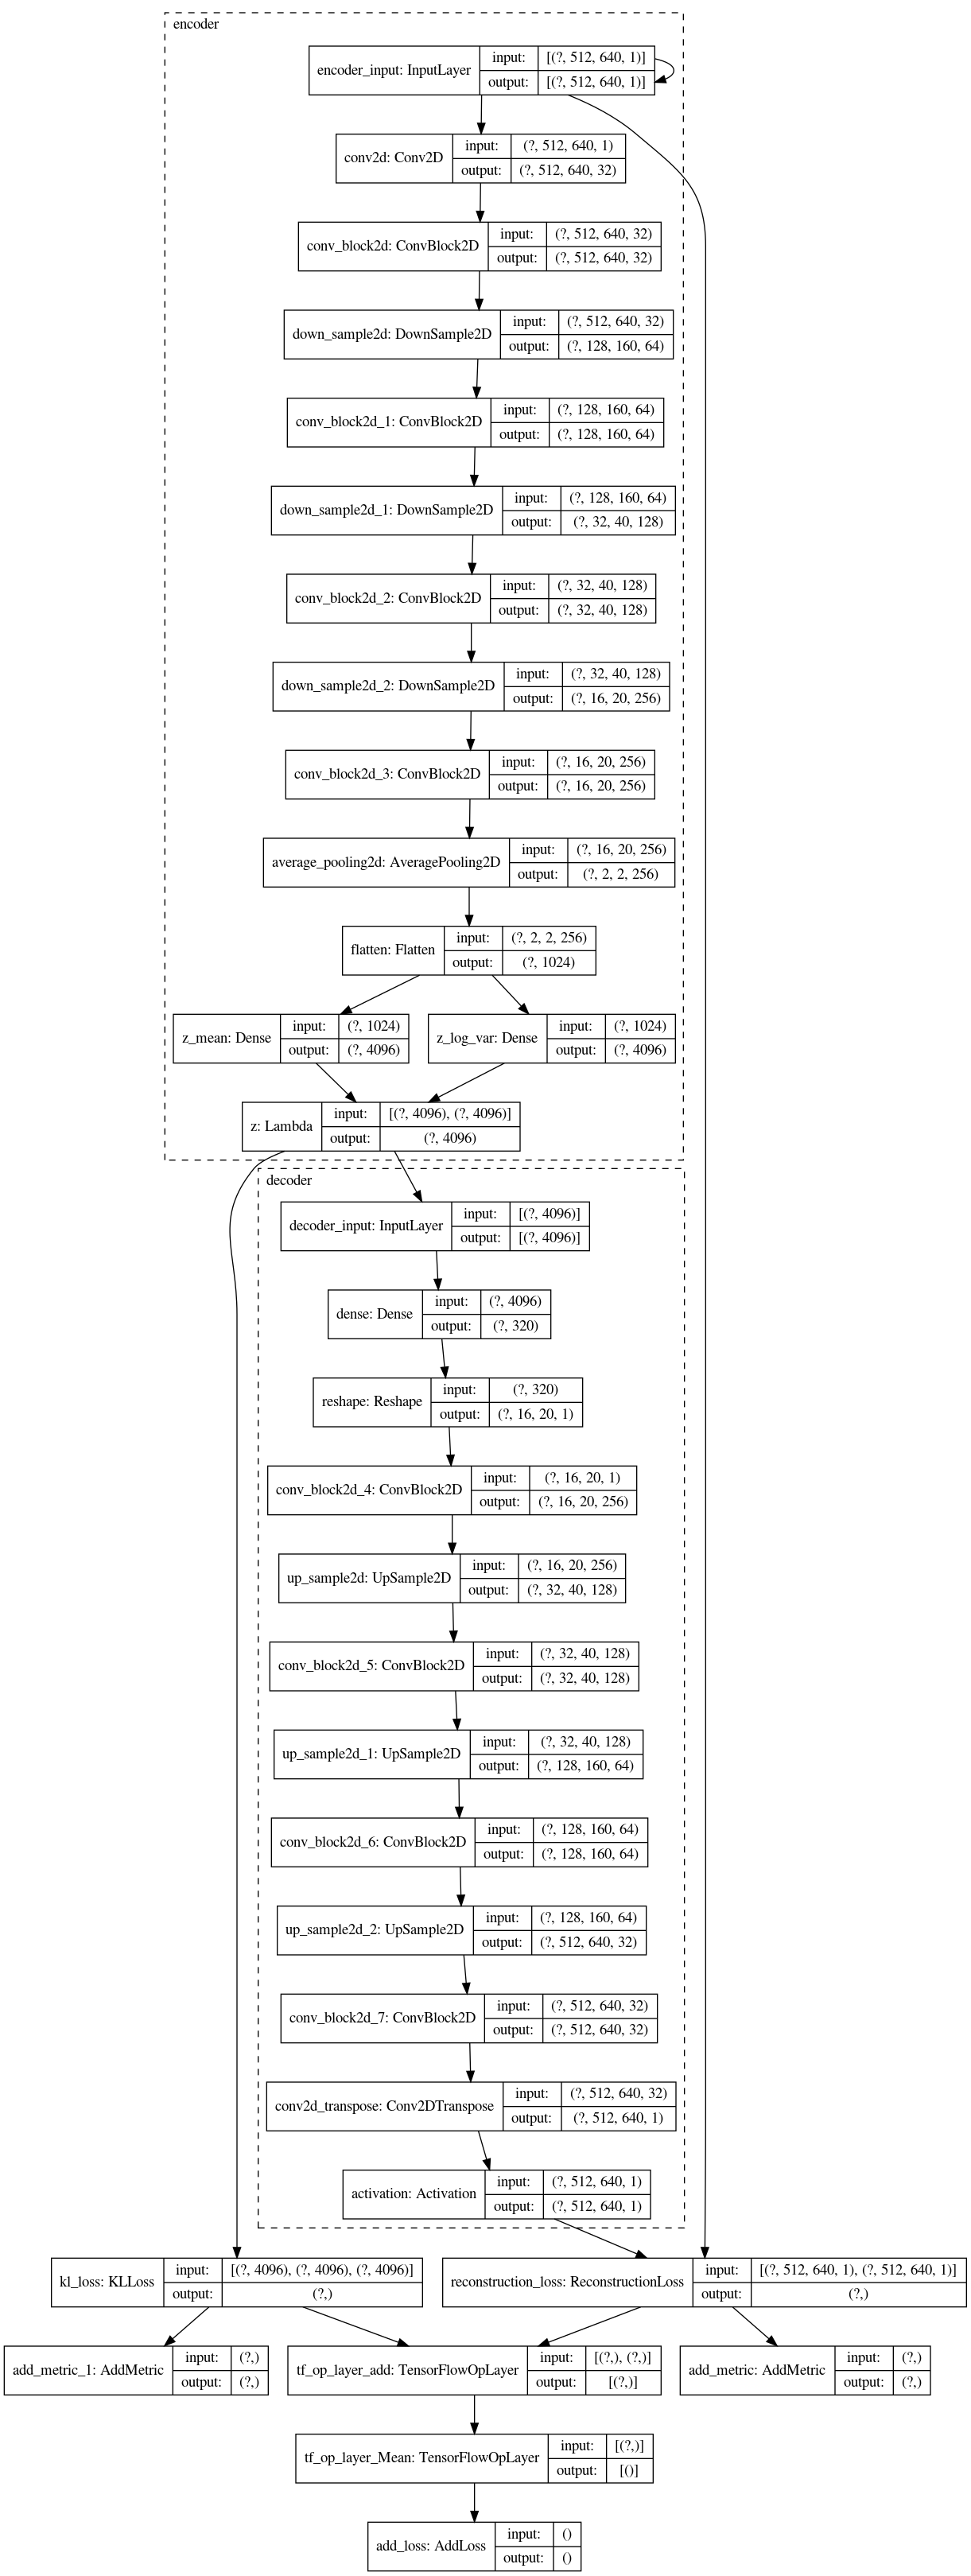

In [12]:
model, encoder, decoder = build_cvae(
    LATENT_DIM,
    IMAGE_DIMS,
    repeat=MODULE_REPEAT,
    use_inception=USE_INCEPTION,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
)
model.summary()
encoder.summary()
decoder.summary()
plot_model(model, to_file=str(LOG_DIR / "model.png"), expand_nested=True, show_shapes=True)

In [ ]:
# Train model
model.fit_generator(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[tensorboard, model_saver, reduce_lr, visualizer,],
    validation_data=val_dataset,
)

Epoch 1/50
 1788/19234 [=>............................] - ETA: 3:38:20 - loss: 25206.2167

In [ ]:
# OR - Overfit model on 1 batch (from the test dataset, to ensure the same sample each time)
single_sample = tf.data.Dataset.from_tensor_slices(list(test_dataset.take(1)))
model.fit_generator(
    single_sample.repeat(LOG_FREQUENCY),
    epochs=EPOCHS,
    callbacks=[tensorboard, VisualizeCallback(LOG_DIR, LATENT_DIM, single_sample, frequency=LOG_FREQUENCY)],
    validation_data=single_sample,
)

### Train on MNIST

In [ ]:
# Load MNIST data
(train_images, _), (val_images, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
val_images = val_images.reshape(val_images.shape[0], 28, 28, 1).astype("float32")
train_images /= 255.0
val_images /= 255.0
mnist_train = (
    tf.data.Dataset.from_tensor_slices(train_images).shuffle(50000).batch(BATCH_SIZE)
)
mnist_val = (
    tf.data.Dataset.from_tensor_slices(val_images).shuffle(50000).batch(BATCH_SIZE)
)

# Callbacks
visualizer = VisualizeCallback(LOG_DIR, LATENT_DIM, mnist_val, frequency=100)

# Define and train model
model, encoder, decoder = build_cvae(
    LATENT_DIM,
    (28, 28, 1),
    num_conv=1,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
)
model.fit_generator(
    mnist_train,
    epochs=200,
    callbacks=[tensorboard, visualizer,],
    validation_data=mnist_val,
)

## Visualize Reconstruction

In [ ]:
# Optional - reload model from disk
model = tf.keras.models.load_model(f"{MODEL_DIR / MODEL_NAME}")
# model = tf.keras.models.load_model(f"../models/cvae.h5")

In [ ]:
sample = next(iter(test_dataset.take(1)))
reconstructed = model.predict(sample)
beatbrain.display.show_spec(
    utils.denormalize_spectrogram(sample[0, ..., 0].numpy()), title="Original"
)
plt.show()
beatbrain.display.show_spec(
    utils.denormalize_spectrogram(model(sample)[0, ..., 0].numpy()),
    title="Reconstructed",
)
plt.show()

## Visualize Unconditioned Generation

In [ ]:
EXAMPLES_TO_GENERATE = 16
INTERPOLATION_POINTS = 9
OUTPUT_DIR = Path("../data/output/images")

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[EXAMPLES_TO_GENERATE, LATENT_DIM]
)

In [ ]:
sample = next(train_dataset.take(1))
beatbrain.display.show_spec(utils.denormalize_spectrogram(sample[0, ..., 0]), title="Orginal")
plt.show()
sns.distplot(train_dataset.flatten())
plt.show()

In [ ]:
prediction = model(train_dataset)
beatbrain.display.show_spec(utils.denormalize_spectrogram(model(sample)[0, ..., 0].numpy()), title="Predicted")
plt.show()
sns.distplot(model(train_dataset).numpy().flatten())

In [ ]:
N_FFT = 4096
HOP_LENGTH = 256
SAMPLE_RATE = 32768

In [ ]:
sample_recon = utils.spectrogram_to_audio(sample[0, ..., 0], denormalize=True, n_fft=N_FFT, hop_length=HOP_LENGTH, sr=SAMPLE_RATE)

In [ ]:
display.Audio(sample_recon, rate=SAMPLE_RATE)

In [ ]:
prediction_recon = utils.spectrogram_to_audio(prediction[0, ..., 0], denormalize=True, n_fft=N_FFT, hop_length=HOP_LENGTH, sr=SAMPLE_RATE)

In [ ]:
display.Audio(prediction_recon, rate=SAMPLE_RATE)

In [ ]:
def generate_and_save_images(decoder, epoch, test_input):
    num_plots = math.ceil(math.sqrt(len(test_input)))
    predictions = sample(LATENT_DIM, decoder, eps=test_input)
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0, wspace=0)
    for i, pred in enumerate(predictions):
        plt.subplot(num_plots, num_plots, i + 1)
        plt.imshow(pred[:, :, 0], cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        output_dir = os.path.join(OUTPUT_DIR, 'progress', str(i))
        os.makedirs(output_dir, exist_ok=True)
        image = Image.fromarray(pred[:, :, 0].numpy(), mode='F')
#         image.save(os.path.join(output_dir, f"epoch_{epoch}.tiff"))
        image.save(os.path.join(output_dir, f"spec.tiff"))
    plt.show()

In [ ]:
from time import time
import librosa

SR = 32768
N_FFT = 4096
N_MELS = 512
HOP_LENGTH = 256
DURATION = 5
A = "../data/fma/audio/000002.mp3"
B = "../data/fma/audio/000005.mp3"

interp_dir = Path(f"interpolation/{int(time())}")
interp_dir.mkdir(exist_ok=True, parents=True)

x, _ = librosa.load(A, sr=SR, duration=DURATION)
y, _ = librosa.load(B, sr=SR, duration=DURATION)
x = librosa.feature.melspectrogram(x, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
y = librosa.feature.melspectrogram(y, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
x, y = x[0, None], y[None, :, None]
print(x.shape)
x_mean, x_logvar = model.encode(x)
y_mean, y_logvar = model.encode(y)

# Reconstruction
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x[0, ..., 0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(122)
x_recon = model.sample(model.reparameterize(x_mean, x_logvar))
plt.imshow(x_recon[0, ..., 0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

# Interpolation
fractions = np.linspace(0, 1, num=INTERPOLATION_POINTS)[:, None]
means = (x_mean * (1 - fractions)) + (y_mean * fractions)  # Interpolated latent vectors
logvars = (x_logvar * (1 - fractions)) + (y_logvar * fractions)  # Interpolated latent vectors
points = model.reparameterize(means, logvars)
interpolated = model.sample(points)

num_plots = math.ceil(math.sqrt(INTERPOLATION_POINTS))
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, wspace=0.03)
for i, pred in enumerate(interpolated):
    Image.fromarray(pred[:, :, 0].numpy(), mode='F').save(interp_dir.joinpath(f'{i}.tiff'))
    plt.subplot(num_plots, num_plots, i + 1)
    if i == 0:
        Image.fromarray(x[0, :, :, 0].numpy(), mode='F').save(interp_dir.joinpath(f'a.tiff'))
        plt.imshow(x[0, ..., 0], cmap='gray', vmin=0, vmax=1)
    elif i == INTERPOLATION_POINTS - 1:
        Image.fromarray(y[0, :, :, 0].numpy(), mode='F').save(interp_dir.joinpath(f'b.tiff'))
        plt.imshow(y[0, ..., 0], cmap='gray', vmin=0, vmax=1)
    else:
        plt.imshow(pred[:, :, 0], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

plt.savefig(interp_dir.joinpath('interpolation.png'), bbox_inches='tight')